This notebook contains the code to download, read and process the policy scenario results 

In [1]:
import os
import sys
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import logging
import boto3
s3_client = boto3.client('s3')

import itertools


logging.basicConfig(
    stream=sys.stdout, level=logging.INFO,
    format='%(asctime)s %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [2]:
sns.set_theme()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("paper")

In [3]:
os.chdir('../')
import kpi
os.chdir('notebooks')

# Download files 

In [4]:
def download_s3(local_file_name,s3_bucket,s3_object_key):
    """
    reference:
    https://stackoverflow.com/questions/41827963/
    track-download-progress-of-s3-file-using-boto3-and-callbacks
    """

    meta_data = s3_client.head_object(Bucket=s3_bucket, Key=s3_object_key)
    total_length = int(meta_data.get('ContentLength', 0))
    downloaded = 0

    def progress(chunk):
        nonlocal downloaded
        downloaded += chunk
        done = int(50 * downloaded / total_length)
        sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )
        sys.stdout.flush()

    logger.info(f'Downloading {s3_object_key}')
    with open(local_file_name, 'wb') as f:
        s3_client.download_fileobj(s3_bucket, s3_object_key, f, Callback=progress)


In [5]:
years = [2021, 2025, 2030, 2035, 2040, 2045, 2050]
scenarios = ['52_base_000','53_scenario_001']
iterator = list(itertools.product(scenarios, years))

for scenario, year in iterator:
    s3_fname = 'kpi_{}_{}.yaml'.format(scenario, year)
    local_fname = '../policy_results/{}/{}'.format(scenario, s3_fname)
    
    s3_bucket = 'carb-results'
    s3_object_key = '{}/{}/{}'.format(scenario, year, s3_fname)
    
    download_s3(local_fname,s3_bucket,s3_object_key)

2022-10-31 11:21:11,756 __main__ - INFO - Downloading 52_base_000/2021/kpi_52_base_000_2021.yaml
[==================================================]2022-10-31 11:21:11,985 __main__ - INFO - Downloading 52_base_000/2025/kpi_52_base_000_2025.yaml
[==================================================]2022-10-31 11:21:12,266 __main__ - INFO - Downloading 52_base_000/2030/kpi_52_base_000_2030.yaml
[==================================================]2022-10-31 11:21:12,497 __main__ - INFO - Downloading 52_base_000/2035/kpi_52_base_000_2035.yaml
[==================================================]2022-10-31 11:21:12,752 __main__ - INFO - Downloading 52_base_000/2040/kpi_52_base_000_2040.yaml
[==================================================]2022-10-31 11:21:12,968 __main__ - INFO - Downloading 52_base_000/2045/kpi_52_base_000_2045.yaml
[==================================================]2022-10-31 11:21:13,251 __main__ - INFO - Downloading 52_base_000/2050/kpi_52_base_000_2050.yaml
[========

# Read results in a DataFrame

In [6]:
def results_to_df(year_result, scenario, year):
    rows = []
    for key, value in year_result.items():
        if key in ['name', 'policy']:
            pass
        elif isinstance(value, dict):
            for k, v in value.items():
                row = pd.Series(data = {'year': year,
                                        'scenario': scenario,
                                        'metric': key, 
                                        'category': k,
                                        'value': v})
                rows.append(row)
        else:
            row = pd.Series(data = {'year': year,
                                    'scenario': scenario,
                                    'metric': key, 
                                    'category': None,
                                    'value': value})
            rows.append(row)
    return pd.concat(rows, axis = 1).T

In [78]:
results = []
for scenario, year in iterator:
    s3_fname = 'kpi_{}_{}.yaml'.format(scenario, year)
    local_fname = '../policy_results/{}/{}'.format(scenario, s3_fname)
    result = kpi.read_yaml(local_fname)
    df = results_to_df(result, scenario, year)
    results.append(df)
    
df = pd.concat(results, axis = 0)
df = df.reset_index(drop = True)

In [79]:
scenarios_dict = {'52_base_000': 'Baseline', 
                  '53_scenario_001': 'Policy Scenario \n Option 1'}
df['scenario'] =df['scenario'].replace(scenarios_dict)

## Plots

In [9]:
def plot_policy_scenario(metric, title, figsize = (8,5)):
    sns.set(rc={'figure.figsize':figsize})
    to_plot = df[df['metric'] == metric]
    
    if to_plot.category.isnull().any():
        sns.lineplot(data = to_plot, 
             x = 'year', 
             y = 'value', 
             hue = 'scenario')
    else:
        sns.lineplot(data = to_plot, 
             x = 'year', 
             y = 'value', 
             hue = 'scenario', 
             style="category")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
           borderaxespad=0, fontsize = 15)
    plt.xlabel('year', fontsize = 25)
    plt.ylabel(title, fontsize = 25)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18);

In [58]:
def cs_plot(df, metric, title, legend_title = None, 
            figsize = (8,5), metric_multiplier = 1.0,
            legend_out = True, loc = 'upper left'):
    data = df[df['metric'] == metric]
    
    if data.category.isnull().any():
        cs = pd.pivot_table(data = data, 
                            values = 'value', 
                            index = 'year', 
                            columns = 'scenario')
        cs['cs'] = cs['Policy Scenario \n Option 1'] - cs['Baseline']
        cs['cs'] = cs['cs'] * metric_multiplier
        cs.reset_index(inplace = True)
        sns.lineplot(data = cs, x = 'year', y ='cs' )
    else: 
        
        cs = pd.pivot_table(data = data, 
                            values = 'value', 
                            index = ['year','category'], 
                            columns = 'scenario')
        cs['cs'] = cs['Policy Scenario \n Option 1'] - cs['Baseline']
        cs['cs'] = cs['cs'] * metric_multiplier
        cs.reset_index(inplace = True)
        sns.lineplot(data = cs, x = 'year', y ='cs', hue = 'category' )
        
        if legend_out:
        
            plt.legend(bbox_to_anchor=(1.05, 1), loc=loc, 
               borderaxespad=0, fontsize = 15, 
                       title = legend_title,title_fontsize = 15 )
        else:
            plt.legend(loc=loc,
                       fontsize = 15, title = legend_title,
                       title_fontsize = 15 )
        
    plt.xlabel('year', fontsize = 25)
    plt.ylabel(title, fontsize = 25)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    return cs

# VMT Plots

In [75]:
df['metric'].unique()

array(['average_commute_trip_lenght', 'average_traveltime_income',
       'average_traveltime_mode', 'average_traveltime_purpose',
       'average_vehicle_ownership', 'cs_per_capita',
       'cs_per_capita_county', 'cs_per_capita_hispanic',
       'cs_per_capita_income', 'cs_per_capita_race', 'mode_shares',
       'seat_utilization', 'total_cs', 'total_vmt', 'transit_ridersip',
       'vmt_per_capita', 'vmt_per_capita_county',
       'vmt_per_capita_hispanic', 'vmt_per_capita_income',
       'vmt_per_capita_race'], dtype=object)

In [90]:
a = df[df.metric.isin(['transit_ridersip'])]
b = pd.pivot_table(data = a, 
                            values = 'value', 
                            index = 'year', 
                            columns = 'scenario')

# (b['Baseline'] - b['Policy Scenario \n Option 1'])/b['Baseline']
# (b['Policy Scenario \n Option 1'] - b['Baseline']).head(10)
b

scenario,Baseline,Policy Scenario \n Option 1
year,,
2021,1766832.0,3192049.0
2025,1680943.0,3026306.0
2030,1721915.0,3102529.0
2035,1764356.0,3160245.0
2040,1798629.0,3218714.0
2045,1828215.0,3290517.0
2050,1853602.0,3321863.0


In [93]:
(1853602.0 - 3321863.0)/1853602.0

-0.7921123304787112

In [92]:
(1853602.0 - 3321863.0)

-1468261.0

In [27]:
b = pd.pivot_table(data = a, 
                            values = 'value', 
                            index = 'year', 
                            columns = 'scenario')

In [31]:
(b['Baseline'] - b['Policy Scenario \n Option 1'])/b['Baseline']

year
2021    0.197223
2025    0.193879
2030    0.198865
2035    0.205167
2040    0.204926
2045    0.205640
2050    0.207157
dtype: float64

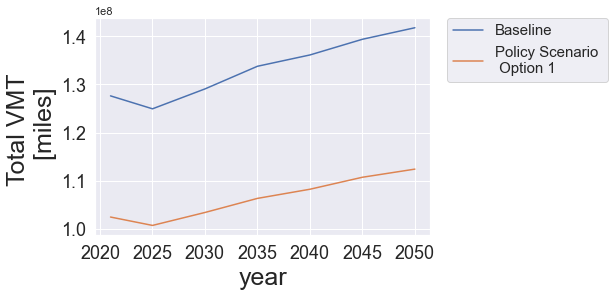

In [11]:
plot_policy_scenario('total_vmt', 'Total VMT \n [miles]', figsize = (8,5))

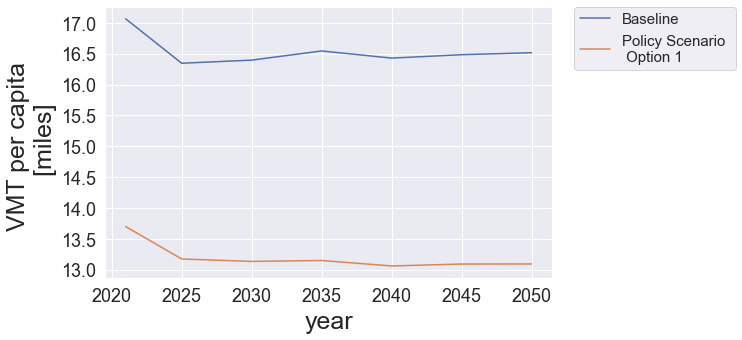

In [12]:
plot_policy_scenario('vmt_per_capita', 'VMT per capita \n [miles]', figsize = (8,5))

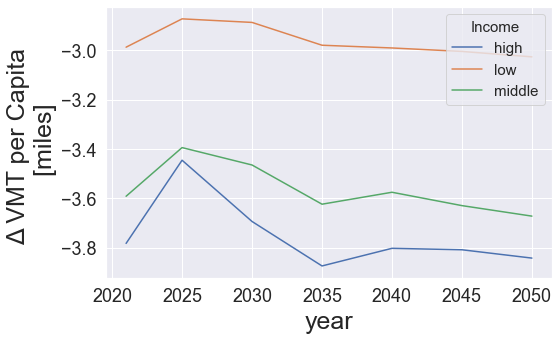

In [20]:
# plot_policy_scenario('vmt_per_capita_income', 'VMT per capita', figsize = (8,5))

cs = cs_plot(df, 'vmt_per_capita_income', 
             '\u0394 VMT per Capita \n [miles]', 
             'Income',
             figsize = (8,5), metric_multiplier = 1, legend_out = False)

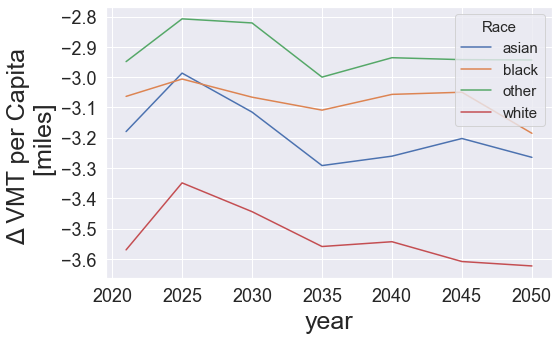

In [21]:
# plot_policy_scenario('vmt_per_capita_race', 'VMT per capita', figsize = (8,5))

cs = cs_plot(df, 'vmt_per_capita_race', 
             '\u0394 VMT per Capita \n [miles]', 
             'Race',
             figsize = (8,5), metric_multiplier = 1, 
            legend_out = False)

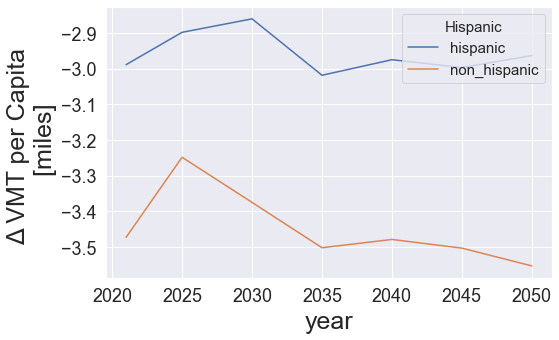

In [22]:
# plot_policy_scenario('vmt_per_capita_hispanic', 'VMT per capita', figsize = (8,5))

cs = cs_plot(df, 'vmt_per_capita_hispanic', 
             '\u0394 VMT per Capita \n [miles]', 
             'Hispanic',
             figsize = (8,5), metric_multiplier = 1, legend_out = False)

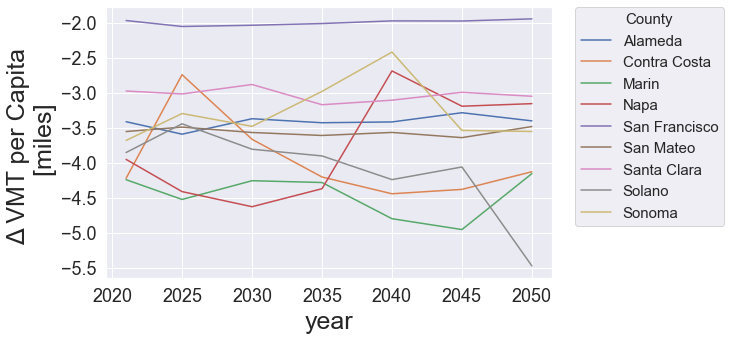

In [290]:
# plot_policy_scenario('vmt_per_capita_county', 'VMT per capita', figsize = (8,5))

cs = cs_plot(df, 'vmt_per_capita_county', 
             '\u0394 VMT per Capita \n [miles]', 
             'County',
             figsize = (8,5), metric_multiplier = 1)

# Consumer Surplus Plots

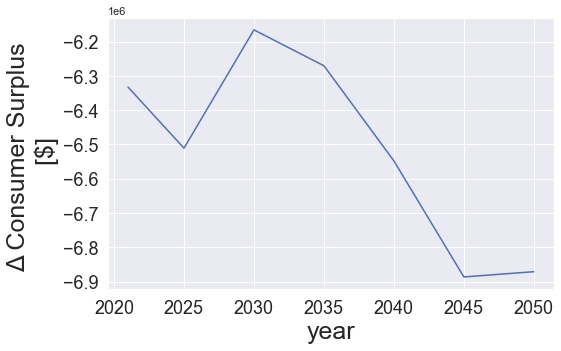

In [296]:
a = cs_plot(df, 'total_cs', '\u0394 Consumer Surplus \n [$]', 
        figsize = (8,5), metric_multiplier = 1/100)

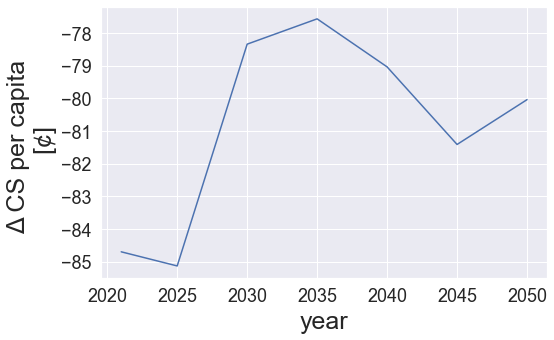

In [94]:
a = cs_plot(df, 'cs_per_capita', '\u0394 CS per capita \n [¢]', figsize = (8,5))

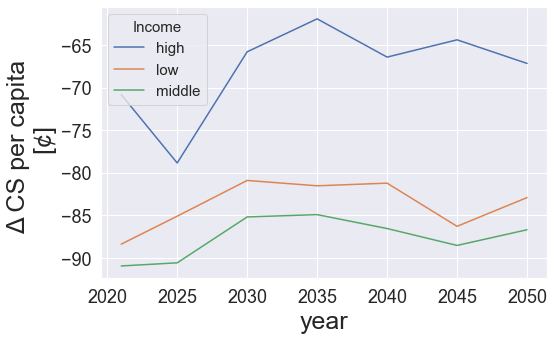

In [104]:
a = cs_plot(df, 'cs_per_capita_income', 
        '\u0394 CS per capita \n [¢]',
        'Income',figsize = (8,5), legend_out = False)

In [110]:
a[(a.category == 'high')].cs.mean()

-67.90081723570003

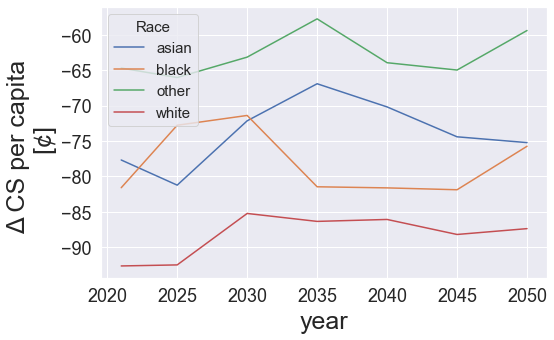

In [100]:
a = cs_plot(df, 'cs_per_capita_race', 
        '\u0394 CS per capita \n [¢]',
        'Race',figsize = (8,5), legend_out = False)

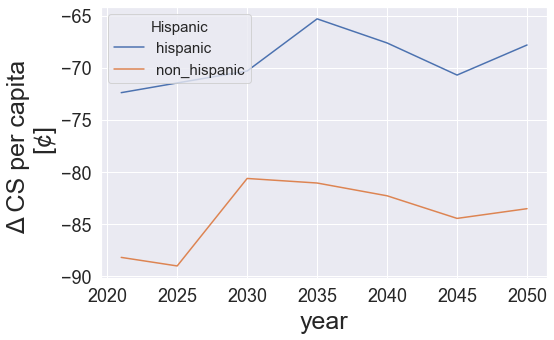

In [101]:
a = cs_plot(df, 'cs_per_capita_hispanic', 
        '\u0394 CS per capita \n [¢]',
        'Hispanic',figsize = (8,5), legend_out = False)

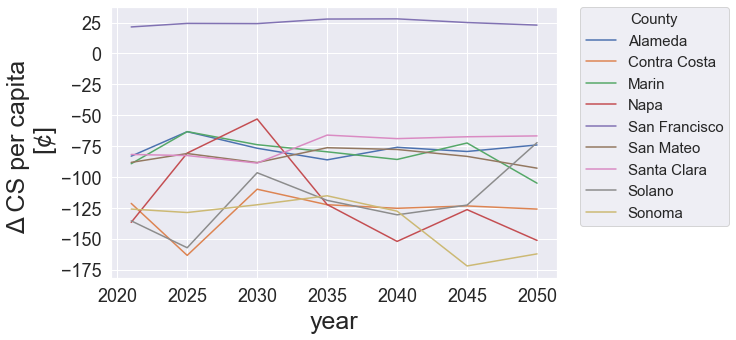

In [103]:
a = cs_plot(df, 'cs_per_capita_county', 
        '\u0394 CS per capita \n [¢]',
        'County',figsize = (8,5))

# Mode Shares

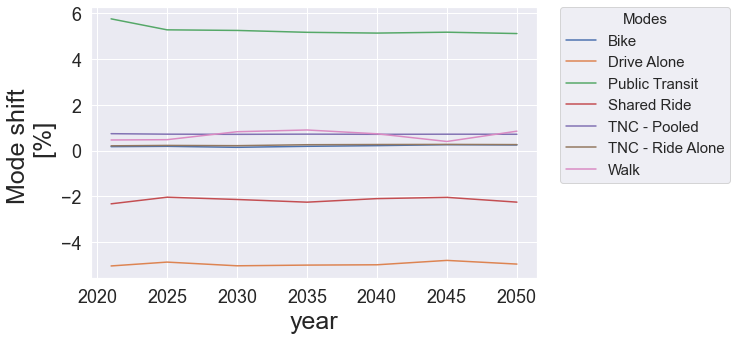

In [43]:
ms = cs_plot(df, 'mode_shares', 
        'Mode shift \n [%]',
        'Modes',figsize = (8,5), 
        metric_multiplier = 100)

In [47]:
ms[ms.year == 2050].sort_values(by = 'cs')

scenario,year,category,Baseline,Policy Scenario \n Option 1,cs
43,2050,Drive Alone,0.455986,0.406407,-4.957965
45,2050,Shared Ride,0.321674,0.299175,-2.249912
42,2050,Bike,0.014960,0.017464,0.250331
47,2050,TNC - Ride Alone,0.032994,0.035655,0.266094
46,2050,TNC - Pooled,0.012604,0.019780,0.717577
48,2050,Walk,0.099158,0.107687,0.852962
44,2050,Public Transit,0.062623,0.113832,5.120913


# Average Travel Times

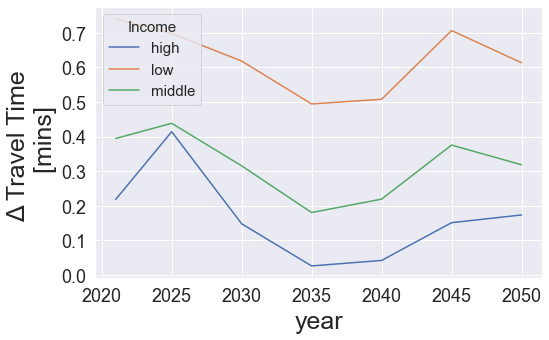

In [64]:
ms = cs_plot(df, 'average_traveltime_income', 
        '\u0394 Travel Time \n [mins]',
        'Income',figsize = (8,5), 
            metric_multiplier = 1, legend_out = False)

In [69]:
ms

scenario,year,category,Baseline,Policy Scenario \n Option 1,cs
0,2021,high,19.378307,19.597036,0.218729
1,2021,low,17.999363,18.739725,0.740362
2,2021,middle,19.449211,19.843983,0.394772
3,2025,high,18.202917,18.617228,0.414310
4,2025,low,16.883427,17.581707,0.698280
5,2025,middle,18.322786,18.761396,0.438610
6,2030,high,18.261961,18.410231,0.148270
7,2030,low,16.795834,17.414265,0.618431
8,2030,middle,18.247356,18.563068,0.315712
9,2035,high,18.216457,18.242935,0.026478


In [68]:
17.82 - 18.20

-0.379999999999999

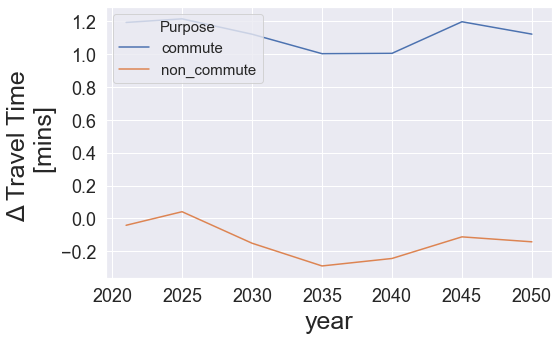

In [70]:
ms = cs_plot(df, 'average_traveltime_purpose', 
        '\u0394 Travel Time \n [mins]',
        'Purpose',figsize = (8,5), 
            metric_multiplier = 1, legend_out = False)

In [71]:
ms

scenario,year,category,Baseline,Policy Scenario \n Option 1,cs
0,2021,commute,19.808044,21.000353,1.192308
1,2021,non_commute,17.664701,17.623360,-0.041342
2,2025,commute,18.740141,19.954277,1.214136
3,2025,non_commute,16.468523,16.509691,0.041168
4,2030,commute,18.671871,19.792658,1.120787
5,2030,non_commute,16.448839,16.298407,-0.150433
6,2035,commute,18.598133,19.600437,1.002304
7,2035,non_commute,16.435526,16.146851,-0.288675
8,2040,commute,18.485102,19.489445,1.004343
9,2040,non_commute,16.269506,16.026262,-0.243244


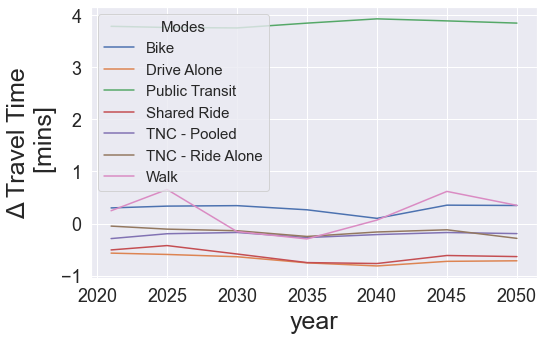

In [72]:
ms = cs_plot(df, 'average_traveltime_mode', 
        '\u0394 Travel Time\n [mins]',
        'Modes',figsize = (8,5), 
            metric_multiplier = 1, legend_out = False, loc = 'upper left')

In [73]:
ms

scenario,year,category,Baseline,Policy Scenario \n Option 1,cs
0,2021,Bike,12.430345,12.731588,0.301244
1,2021,Drive Alone,19.648247,19.082125,-0.566122
2,2021,Public Transit,26.987623,30.773022,3.785398
3,2021,Shared Ride,17.385130,16.880302,-0.504827
4,2021,TNC - Pooled,14.773608,14.486418,-0.287190
5,2021,TNC - Ride Alone,12.265676,12.217882,-0.047793
6,2021,Walk,16.745855,16.992809,0.246954
7,2025,Bike,11.649508,11.985109,0.335601
8,2025,Drive Alone,18.820866,18.229311,-0.591555
9,2025,Public Transit,27.323534,31.086563,3.763029


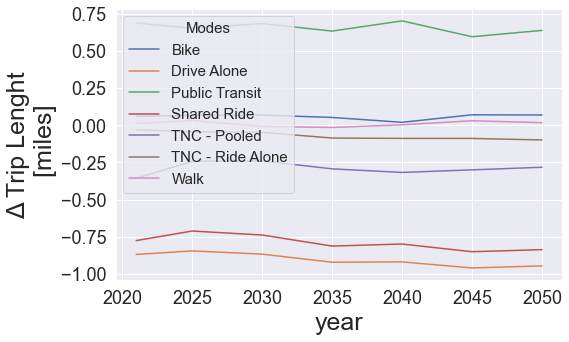

In [62]:
ms = cs_plot(df, 'average_commute_trip_lenght', 
        '\u0394 Trip Lenght\n [miles]',
        'Modes',figsize = (8,5), 
            metric_multiplier = 1, legend_out = False, loc = 'upper left')

# Ridership

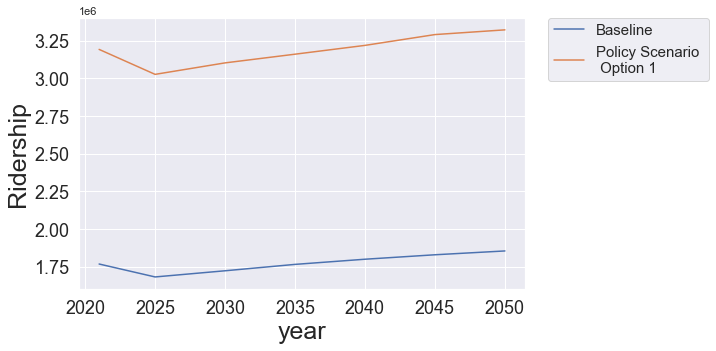

In [309]:
plot_policy_scenario('transit_ridersip', 'Ridership', figsize = (8,5))

# Average Vehicle Ownership

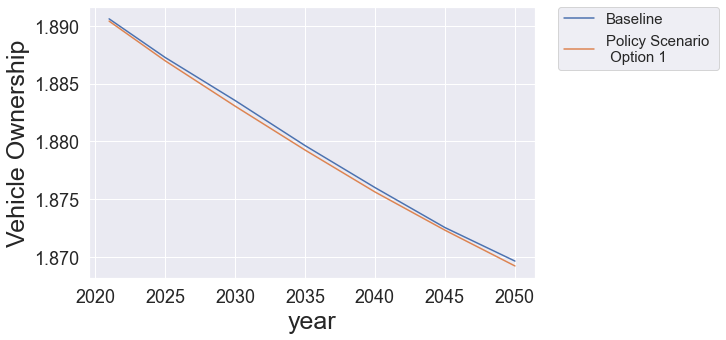

In [310]:
plot_policy_scenario('average_vehicle_ownership', 'Vehicle Ownership', figsize = (8,5))

# Seat Utilization

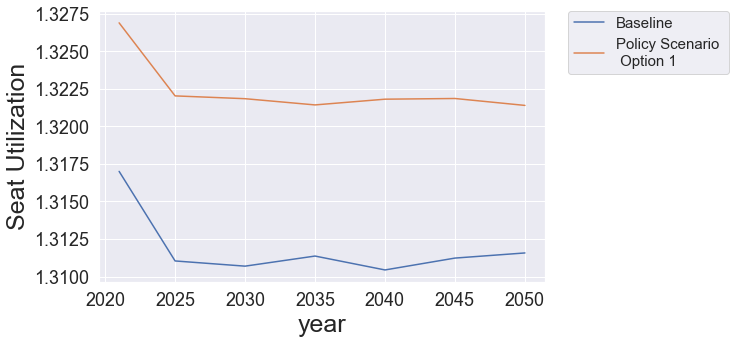

In [311]:
plot_policy_scenario('seat_utilization', 'Seat Utilization', figsize = (8,5))

## Consumer surplus plots

In [251]:
# def cs_plot(df, metric, title, legend_title = None, figsize = (8,5), metric_multiplier = 1.0):
#     data = df[df['metric'] == metric]
    
#     if data.category.isnull().any():
#         cs = pd.pivot_table(data = data, 
#                             values = 'value', 
#                             index = 'year', 
#                             columns = 'scenario')
#         cs['cs'] = cs['Policy Scenario \n Option 1'] - cs['Baseline']
#         cs['cs'] = cs['cs'] * metric_multiplier
#         cs.reset_index(inplace = True)
#         sns.lineplot(data = cs, x = 'year', y ='cs' )
#     else: 
        
#         cs = pd.pivot_table(data = data, 
#                             values = 'value', 
#                             index = ['year','category'], 
#                             columns = 'scenario')
#         cs['cs'] = cs['Policy Scenario \n Option 1'] - cs['Baseline']
#         cs['cs'] = cs['cs'] * metric_multiplier
#         cs.reset_index(inplace = True)
#         sns.lineplot(data = cs, x = 'year', y ='cs', hue = 'category' )
        
#         plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
#            borderaxespad=0, fontsize = 15, 
#                    title = legend_title,title_fontsize = 15 )
        
#     plt.xlabel('year', fontsize = 25)
#     plt.ylabel(title, fontsize = 25)
#     plt.xticks(fontsize=18)
#     plt.yticks(fontsize=18)
#     return cs